In [1]:
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko
from pathlib import Path
import ruamel.yaml as yaml
from tqdm.notebook import tqdm
import scipy.stats as stats
import pandas as pd
%matplotlib inline

print("TensorFlow Ver: ", tf.__version__)

TensorFlow Ver:  2.1.0


In [2]:
        
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
# Eager by default!
print("Eager Execution:", tf.executing_eagerly())
print("1 + 2 + 3 + 4 + 5 =", tf.reduce_sum([1, 2, 3, 4, 5]))

Eager Execution: True
1 + 2 + 3 + 4 + 5 = tf.Tensor(15, shape=(), dtype=int32)


In [5]:
class dist_env():
    #this is pretty much the same as before, just that you can add some more values when initialising the environment
    def __init__(self, n_timesteps=1000, keep_record=True, right_reward = 1, wrong_reward = -1, wait_reward = -.1, observation_sigma = 1):
        self.keep_record = keep_record
        self.n_timesteps = n_timesteps
        self.n_states = 4
        self.stay_prob = 1 -1/20
        self.M_weighting_off_diagonal = 0.1
        self.wait_reward = wait_reward
        self.wrong_reward = wrong_reward
        self.right_reward = right_reward
        self.observation_sigma = observation_sigma
        self.reset()


    def reset(self, ):
        self.reset_M()
        self.reset_M_random()
        self.done = False
        self.t = 0
        reward = self.wait_reward
        
        self.state = np.random.randint(0, self.n_states)
        observation = self.compute_observation(self.state) #changed this so we get an observation based on state instead of just 0
        
        #just initialised these to the final length (just a personal preference)
        self._s_hist = np.zeros(self.n_timesteps +1) #np.array([self.state])
        self._s_hist[0] = self.state
        self._r_hist = np.zeros(self.n_timesteps)
        self._o_hist = np.zeros(self.n_timesteps +1)
        self._o_hist[0] = observation
        self._a_hist = np.zeros(self.n_timesteps)
        
        return observation, reward, self.done, self.t        


    def reset_M(self, ):
        self.trans_prob = (1.-self.stay_prob) / (self.n_states-1)
        self.M = np.eye(self.n_states) * self.stay_prob
        self.M[np.logical_not(np.eye(self.M.shape[0], dtype=bool))] = self.trans_prob


    def reset_M_random(self, ):
        M = np.identity(self.n_states)
        M += self.M_weighting_off_diagonal*np.random.lognormal(size=M.shape)
        M /=np.sum(M, axis=1, keepdims=True)
        self.M = M

    def step(self, action):
        assert not self.done
        state = self.state
        reward = self.comp_reward(action, state)
        new_state = self.comp_transition(action, state)
        observation = self.compute_observation(new_state) 
        
        self.t += 1
        if self.t >= self.n_timesteps:
            self.done = True
        self.state = new_state
        
        if self.keep_record:
            #changed these so just inserting add the index instead of appending to the arrays(just a personal preference again)
            self._r_hist[self.t-1] = reward
            self._s_hist[self.t] = new_state
            self._o_hist[self.t] = observation
            self._a_hist[self.t-1] = action
            
        return observation, reward, self.done, self.t
    
    def comp_reward(self, action, state):
        if action == self.n_states:
            reward = self.wait_reward
        elif action == state:
            reward = self.right_reward
        else:
            reward = self.wrong_reward
                    
        return reward
    
    def comp_transition(self, action, state):
        if self.stay_prob == 1:
            if action == self.n_states:
                return state
        new_state = np.random.choice(self.n_states, p=self.M[state,:]) #waiting transition, the diagonal probability
        if action != self.n_states:
            while new_state == state:
                new_state = np.random.choice(self.n_states, p=self.M[state,:])
        return new_state

    def compute_observation(self, state):
        observation = stats.norm.rvs(loc=state, scale=self.observation_sigma)
        return observation

In [6]:
def get_probabilities(old_probs, env, i, playing = False, decision_boundary = 0):
    """
    Calculates the probabilities for a dist_env object to be in a certain state based on the previous probabilities,
    the previous reward, the new observation and knowledge of the environment
    """
    rv = stats.norm(0, env.observation_sigma)
    
    if i == 0:
        old_probs = np.ones(env.n_states)
    p_o = rv.pdf(env._o_hist[i] - np.arange(env.n_states)) #probability density of getting an observation given state
    cur_probs = p_o*old_probs #cur_probs is the probability to be returned at this timestep before reward is given
    cur_probs = cur_probs/sum(cur_probs)
    
    #this part is if you let an agent that can calculate the probabilities play the environment
    # here decicion boundary indicates the threshold that you want the certainty to be greater than
    if playing == True:
        max_index = np.argmax(cur_probs)
        if cur_probs[max_index] >= decision_boundary:
            env.step(max_index)
        else:
            env.step(4)
    
    # Next part calculates the actual probability, in the three cases that it guesses right, wrong or waits.
    
    #modify probs that gets sent to next iteration based on action and validity of action.
    #new_probs is the probability after getting the reward (we know that the state is then either equal to or not
    #not equal to the action).
    if env._r_hist[i] == env.right_reward: #state is equal to action
        new_probs = env.M[int(env._a_hist[i]), :].copy() #the probabilities of changing to each state given current state
        new_probs[int(env._a_hist[i])] = 0 #probability of current state should be 0
        new_probs = new_probs/sum(new_probs) #normalised
        return cur_probs, new_probs
    
    if env._r_hist[i] == env.wrong_reward: #now the previous action was not the previous state, and the state has changed
        old_probs[int(env._a_hist[i])] = 0 # our action was not the previous state
        old_probs = old_probs*p_o/sum(old_probs*p_o) #the new normalised probabilities knowing s != a
        #now add in that it changes according to the env.M matrix
        #want to multiply 1-the 'old_probs' by each row of the env.M matrix and then sum the columns
        m = env.M.copy()
        np.fill_diagonal(m, 0) # the probability of staying should be 0 (because it has to change state)
        m = (m.T*(old_probs)).T #multiply the rows
        new_probs = sum(m)/sum(sum(m)) #sum over columns and normalise
        return cur_probs, new_probs
    
    if env._r_hist[i] == env.wait_reward: #now we are waiting
        if env.stay_prob ==1:
            return cur_probs, cur_probs
        # need to multipli the prob of being in a state by the prob of changing to another and the sum up
        new_probs = sum((env.M.T*cur_probs).T)
        new_probs = new_probs / sum(new_probs)
        return cur_probs, new_probs
        
        
def action_values(env):
    """
    calculate and return the probabilities and expected values for different actions in an environment
    that has already been played through. Also returns the best actions
    """
    eM = env.M.copy()
    p = np.zeros((env.t, 4))
    n = 0
    for i in range(env.t):
        c, n = get_probabilities(n, env, i)
        p[i] = c
        
    e = np.zeros((env.t, 5))
    e[:,:4] = env.wrong_reward + p*(env.right_reward - env.wrong_reward)
    e[:,4] = env.wait_reward
    
    best = np.argmax(e, axis = 1)
    return p,e, best

def play_env(env, steps, decision_boundary = 0):
    """
    function that plays through an environment, picking the actions that most likely equal to the state
    (I have mostly used this to test that the get_probabilities actually works)
    """
    n = 0
    for i in range(steps):
        c, n = get_probabilities(n, env, i, True, decision_boundary)
    return env

In [7]:
def plot_waitmoves(env):
    """
    function to plot where an agent agent has taken waiting moves and what the probabilities here where
    """
    plt.figure(figsize = (12,12))
    for i in range(4):
        plt.subplot(221 + i)
        plt.plot(np.arange(env.t), p[:,i])
        eq = np.zeros(env.t)
        eq[np.where(env._s_hist[:env.t] == i)] = 0.5
        plt.plot(np.arange(env.t), eq)
        plt.ylim(0,1)

def plot_moves(env, start = 0, end = False):
    """
    function to plot probabilities, moves of an agent and observations
    """
    p = action_values(env)
    if end == False:
        end = env.t
    x = np.arange(len(env._s_hist[start:end]))
    plt.figure(figsize = (16, 4))
    plt.subplot(131)
    plt.plot(x, p[start:end,0], 'b')
    plt.plot(x, p[start:end,1], 'g')
    plt.plot(x, p[start:end,2], 'r')
    plt.plot(x, p[start:end,3], 'y')
    plt.subplot(132)
    plt.plot(x, env._s_hist[start:end])
    plt.subplot(133)
    plt.plot(x, env._o_hist[start:end])

In [8]:
#Testing how well the computational model performs
# n = 1000
# s = np.zeros(n)
# for i in range(n):
#     env = play_env(100, 0.45)
#     s[i] = np.sum(env._r_hist)
# print(np.sum(s)/n)

# env = dist_env()
# for i in range(10):
#     env.step(1)

# plot_moves(env, end = 20)
# print(env.M)

In [9]:
env = dist_env(100, wrong_reward = -10)
env = play_env(env, 10)
p,e, best = action_values(env)


In [10]:
(np.diff(env._s_hist) == 0)[:15], env._s_hist[:15]

(array([False, False, False, False, False, False, False, False, False,
        False,  True,  True,  True,  True,  True]),
 array([2., 3., 0., 2., 3., 0., 3., 0., 1., 2., 0., 0., 0., 0., 0.]))

In [11]:
np.unique(env._s_hist[:-1][(np.diff(env._s_hist) == 0)], return_counts=True)

(array([0.]), array([90], dtype=int64))

In [12]:
env.reset()

(1.2627854988990885, -0.1, False, 0)

In [13]:
env.step(0)

(2.464392325050896, -10, False, 1)

In [14]:
class Model(tf.keras.Model):
    def __init__(self, num_actions, batch_size=1, n_timesteps=None, n_features=8, name='meta_policy'):
        super().__init__(name)
#         Having a stateful LSTM means that you will need to reset the hidden state 
#         in between batches yourself if you do want independent batches. 
#         The default initial hidden state in Tensorflow is all zeros.
        self.lstm = kl.LSTM(
            48, name='hidden', 
            stateful=True, 
            time_major=True, # ['time', 'batch', 'features']
            return_sequences=True, 
            recurrent_initializer='zeros'
        )
        self.lstm.build((n_timesteps, batch_size, n_features)) # set batch size, must be done with stateful lstm
#         self.noise = kl.GaussianNoise(0.1)
        self.policy = kl.Dense(
            num_actions, name='policy'
        )
        self.value = kl.Dense(
            1, name='value'
        )

    def call(self, inputs, **kwargs):
        output = self.lstm(inputs)
        value = self.value(output)
        policy = self.policy(output)
#         noise = self.noise(output, training=True)
#         policy = self.policy(noise)
        return tf.squeeze(policy, 1), tf.squeeze(value, (1, 2))

    def predict_action_value(self, obs):
        # Executes `call()` under the hood.
        policy, value = self.predict_on_batch(obs)
        actions = tf.squeeze(tf.random.categorical(policy, 1), 1)
        return actions, value 

In [15]:
# Verify everything works by sampling two actions.
state_observation, reward, done, timestep = env.reset()
model = Model(env.n_states + 1, n_features=8)
action = 0
action = tf.one_hot(action, env.n_states + 1)
observation = np.concatenate([
        [[state_observation], [state_observation]],
        [[reward],[reward]], 
        [action, action],
        [[timestep], [timestep]]], 1)
observation = tf.expand_dims(observation, [1])
# print(observation)
action, value = model.predict_action_value(observation)
print(action, value)

tf.Tensor([1 3], shape=(2,), dtype=int64) tf.Tensor([-0.08297977 -0.13654235], shape=(2,), dtype=float32)


In [16]:
# Verify everything works by sampling two actions with state reset.
state_observation, reward, done, timestep = env.reset()
model = Model(env.n_states + 1, n_features=8)

action = 0
for _ in range(2):
    action = tf.one_hot(action, env.n_states + 1)
    single_input = np.concatenate([
        [[state_observation]],
        [[reward]],
        [action],
        [[timestep]]], 1)
    single_input = tf.cast(single_input, dtype=tf.float32)
    single_input = tf.expand_dims(single_input, [1])

    action, value = model.predict_action_value(single_input)
    action = np.squeeze(action)
    state_observation, reward, done, timestep = env.step(action)
    print(action, value.numpy(), state_observation, reward)
    

1 [0.00829638] 0.45637561913725166 -10
1 [0.36973652] 2.4541278045537407 1


In [17]:
class Agent:
    def __init__(self, model, env, learning_rate=1e-3, gamma=0.8, value_coefficient=0.2, entropy_coefficient=.002, name='a2c_agent_alex', data_path=None):
        # `gamma` is the discount factor; coefficients are used for the loss terms.
        self.gamma = gamma
        self.value_coefficient = value_coefficient
        self.learning_rate = learning_rate
        self.entropy_coefficient = entropy_coefficient
        self.env =  env
        self.name = name
        self.model = model(env.n_states + 1, batch_size=1, name=self.name)
        # Define separate losses for policy logits and value estimate.
        self.data_path = data_path or Path().cwd() / self.name
        self.parameters = {
            'learning_rate': learning_rate,
            'value_coefficient': value_coefficient,
            'entropy_coefficient': entropy_coefficient,
            'gamma': gamma 
        }
        self._compile()
    
    def save_agent(self):
        self.data_path.mkdir(parents=True, exist_ok=True)
        logging.info(f"Saving parameters, training_history and weights to {self.data_path}.")
        with open(str(self.data_path / self.name) + '.yaml', 'w') as f:
            yaml.dump(self.parameters, f)
        np.save(str(self.data_path / self.name) + '.npy', self.training_history)
        self.model.save_weights(str(self.data_path / self.name))
        
    def load_agent(self):
        logging.warning("Updating parameters, training_history, weights and recompiling model.")
        with open(str(self.data_path / self.name) + '.yaml', 'r') as f:
            self.parameters = yaml.load(f, Loader=yaml.Loader)
        self.training_history = np.load(str(self.data_path / self.name) + '.npy')
        self.model.load_weights(str(self.data_path / self.name))
        self.__dict__.update(self.parameters)
        self._compile()
        
    def _compile(self):
        self.model.compile(
            optimizer=ko.Adam(lr=self.learning_rate), 
            loss=[self._policy_loss, self._value_loss])
    
    def _predict(self, action, state_observation, reward, timestep):
        action = np.squeeze(action)
        action = tf.one_hot(action, self.env.n_states + 1)
        single_input = np.concatenate([
            [[state_observation]],
            [[reward]],
            [action],
            [[timestep]]], 1)
        single_input = tf.cast(single_input, dtype=tf.float32)
        single_input = tf.expand_dims(single_input, [1])
        new_action, value = self.model.predict_action_value(single_input)
        return new_action, value, single_input

    def train(self, episodes=250):
        # Training loop: collect samples, send to optimizer, repeat episodes times.
        self.training_history = []
        for episode in tqdm(range(episodes)):
            actions, observations, rewards, values, inputs = self.run_episode()
            self.training_history.append(np.sum(rewards))

            logging.info(f"Episode: {len(self.training_history) - 1:3d}, Reward: {int(self.training_history[-1]):3d}")
            
            # `next_value` is the bootstrap value estimate of the future state (critic).
            _, next_value, _ = self._predict(actions[-1], observations[-1], rewards[-1], inputs[-1,0,3] + 1)

            self.model.reset_states()
            
            returns, advantages = self._returns_advantages(rewards, values, next_value)
            # A trick to input actions and advantages through same API.
            actions_advantages = np.concatenate([actions[:, None], advantages[:, None]], axis=1)
            
            losses = self.model.train_on_batch(inputs, [actions_advantages, returns])
            
            logging.debug(f"[{episode + 1:d}/{episodes:d}] Losses: {losses}")
        return self.training_history

    def run_episode(self):
        state_observation, reward, done, timestep = self.env.reset()

        action = 4 # I don't know
        # Storage helpers for a single batch of data.
        actions = np.empty(self.env.n_timesteps, dtype=np.int32)
        rewards, values, observations = np.empty((3, self.env.n_timesteps))
        inputs = np.empty((self.env.n_timesteps, 1, 8))
        
        self.model.reset_states()
        step = 0
        while not done:
            # action and reward at t - 1 and timestep at t
            action, value, inputs[step] = self._predict(action, state_observation, reward, timestep + 1)
            state_observation, reward, done, timestep = self.env.step(action)
            # rewards, values and actions at t
            observations[step] = state_observation
            rewards[step] = reward
            actions[step] = action
            values[step] = value
            step += 1
        return actions, observations, rewards, values, inputs
    
    def _returns_advantages(self, rewards, values, next_value):
        # `next_value` is the bootstrap value estimate of the future state (critic).
        returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
        # Returns are calculated as discounted sum of future rewards.
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        returns = returns[:-1]
        # Advantages are equal to returns - baseline (value estimates in our case).
        advantages = returns - values
        return returns, advantages

    def _value_loss(self, returns, value):
        # Value loss is typically MSE between value estimates and returns.
        loss = self.value_coefficient * kls.mean_squared_error(returns, value)
#         tf.keras.backend.print_tensor(loss)
        return loss

    def _policy_loss(self, actions_and_advantages, logits):
        # A trick to input actions and advantages through the same API.
        actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)
        # Sparse categorical CE loss obj that supports sample_weight arg on `call()`.
        # `from_logits` argument ensures transformation into normalized probabilities.
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
        # Policy loss is defined by policy gradients, weighted by advantages.
        # Note: we only calculate the loss on the actions we've actually taken.
        actions = tf.cast(actions, tf.int32)
        policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)
        # Entropy loss can be calculated as cross-entropy over itself.
        probs = tf.nn.softmax(logits)
        entropy_loss = tf.reduce_sum(kls.categorical_crossentropy(probs, probs))
        # We want to minimize policy and maximize entropy losses.
        # Here signs are flipped because the optimizer minimizes.
#         tf.keras.backend.print_tensor(policy_loss)
#         tf.keras.backend.print_tensor(entropy_loss)
        loss = policy_loss - self.entropy_coefficient * entropy_loss
        return loss

In [18]:
# logging.getLogger().setLevel(logging.INFO)
# logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.WARNING)

env = dist_env(n_timesteps=100)
agent = Agent(Model, env)

actions, observations, rewards, values, inputs = agent.run_episode()
print(sum(rewards))

-40.6


(array([67.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0., 27.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

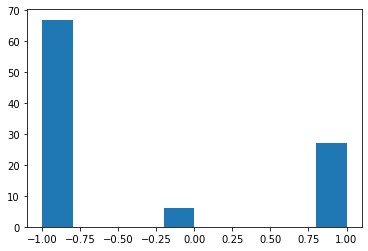

In [19]:
plt.hist(rewards)

# train

In [ ]:

env = dist_env(n_timesteps = 100, right_reward = 1, wrong_reward = -1, wait_reward = -0.1, observation_sigma = 0.5)
agent = Agent(Model, env, name = "alex_sigma_1o2")
agent.train(20000)
agent.save_agent()
del env
del agent
env = dist_env(n_timesteps = 100, right_reward = 1, wrong_reward = -1, wait_reward = -0.1, observation_sigma = 0.2)
agent = Agent(Model, env, name = "alex_sigma_1o5")
agent.train(20000)
agent.save_agent()

# for i in [6,7]:
#     del env
#     del agent
#     env = dist_env(n_timesteps = 100, right_reward = i, wrong_reward = -10, wait_reward = 0)
#     name = f"a2c_alex_ratio_{i}o10"
#     agent = Agent(Model, env, name = name)
#     agent.train(20000)
#     agent.save_agent()
    


Finished training! Testing...
Total Episode Reward: 25 out of 100


# or load weights

In [32]:
agent.save_agent()

In [20]:
agent.load_agent()

'a2c_agent_alex'

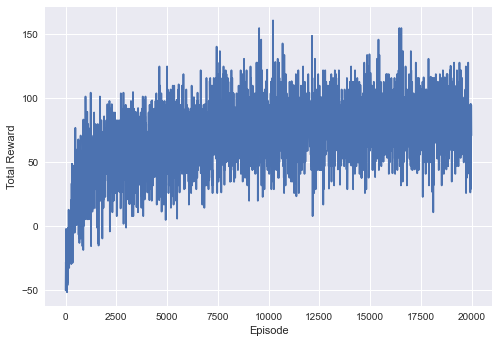

In [21]:
plt.style.use('seaborn')
plt.plot(np.arange(0, len(agent.training_history), 5), agent.training_history[::5])
# plt.plot(np.arange(len(training_history)), training_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
agent.name

# analyze model

In [20]:
class Benchmark:
    def __init__(self, agent, env, n_episodes=300):
        assert env.keep_record
        self.agent = agent
        self.env = env
        self.n_episodes = n_episodes
    
    def evaluate(self):
        #Here there where a lot of places were it just said env.n_timesteps instead of self.env.n_timesteps
        #took a while to realise what what going on when i trained different models and everything looked the same..
        rewards = np.empty((self.n_episodes, self.env.n_timesteps))
        actions = np.empty((self.n_episodes, self.env.n_timesteps))
        observations = np.empty((self.n_episodes, env.n_timesteps))
        values = np.empty((self.n_episodes, self.env.n_timesteps))
        states = np.empty((self.n_episodes, self.env.n_timesteps))
        best = np.empty((self.n_episodes, self.env.n_timesteps))
        for episode in tqdm(range(self.n_episodes)):
            actions[episode], observations[episode], rewards[episode], values[episode], _ = self.agent.run_episode()
            states[episode] = self.env._s_hist[:-1]
            p, e, b = action_values(self.env)
            best[episode] = b
        self.episodes = {
            'rewards': rewards,
            'observations': observations,
            'actions': actions,
            'values': values,
            'states': states,
            'best': best
        }
                
    def plot_rewards(self):
        import matplotlib.patches as mpatches
        if not hasattr(self, 'episodes'):
            self.evaluate()

        im = plt.imshow(self.episodes['rewards'], cmap='binary', origin='lower', interpolation='nearest')
        
        patches = [mpatches.Patch(color=im.cmap(im.norm(0)), label="Sub-optimal choice")]
        plt.legend(handles=patches, )
        
        plt.gca().set_aspect('auto')
        plt.grid(False)
    
    def plot_actions(self):
        import matplotlib.patches as mpatches
        if not hasattr(self, 'episodes'):
            self.evaluate()
        actions_optimal = np.empty_like(self.episodes['actions'])
        _itr = zip(self.episodes['actions'], self.episodes['states'])
        
        for i, (actions_episode, states_episode) in enumerate(_itr):
            for j, (action, state) in enumerate(zip(actions_episode, states_episode)):
                actions_optimal[i, j] = action == state

        im = plt.imshow(actions_optimal, cmap='Greens_r', origin='lower', interpolation='nearest')
        
        patches = [mpatches.Patch(color=im.cmap(im.norm(0)), label="Sub-optimal choice")]
        plt.legend(handles=patches, )
        print(patches)
        
        plt.gca().set_aspect('auto')
        plt.grid(False)

In [33]:
#Rest below is just experiments that I've run, not really any useful results but I have the trained agents and csv files
#in case they are of any use.

env = dist_env(n_timesteps = 100, right_reward = 1, wait_reward = -.1, wrong_reward = -1, observation_sigma = 0.5)
a1 = Agent(Model, env, name = 'alex_sigma_1o5')
a2 = Agent(Model, env, name = 'alex_sigma_1o2')
a3 = Agent(Model, env, name = 'a2c_agent_alex')

a1.load_agent()
a2.load_agent()
a3.load_agent()
# print(agent.env.observation_sigma)
b1 = Benchmark(a1, env)
b1.evaluate()
b2 = Benchmark(a2, env)
b2.evaluate()
b3 = Benchmark(a3, env)
b3.evaluate()

In [34]:
# print(b.episodes['rewards'].mean())

# n,m = b.episodes['actions'].shape


# np.sum(b.episodes['actions'] == b.episodes['best'])/(n*m)
# best
rewards = [b1.episodes['rewards'].mean(), b2.episodes['rewards'].mean(), b3.episodes['rewards'].mean()]
# best += [np.sum(b.episodes['actions'] == b.episodes['best'])/(n*m)]

In [21]:
# df1 = pd.DataFrame()
# df2 = pd.DataFrame()
df1 = pd.read_csv('sigma_best.csv')
# df1['sigma1o1'] = best
df2 = pd.read_csv('sigma_rewards.csv')
# df2['sigma1o2'] = rewards
# df4 = pd.DataFrame()
# df4['sigma1o5'] = df1['sigma1o5']
# df4['sigma1o2'] = df1['sigma1o2']
# df4['sigma1o1'] = df1['sigma1o1']
df2
# rewards

,sigma1o5,sigma1o2,sigma1o1
0,0.978763,0.564613,0.087897
1,0.936247,0.618257,0.201910
2,0.515357,0.427740,0.171497


In [36]:
# df1.to_csv('sigma_best.csv', index = False)
# df2.to_csv('sigma_rewards.csv', index = False)

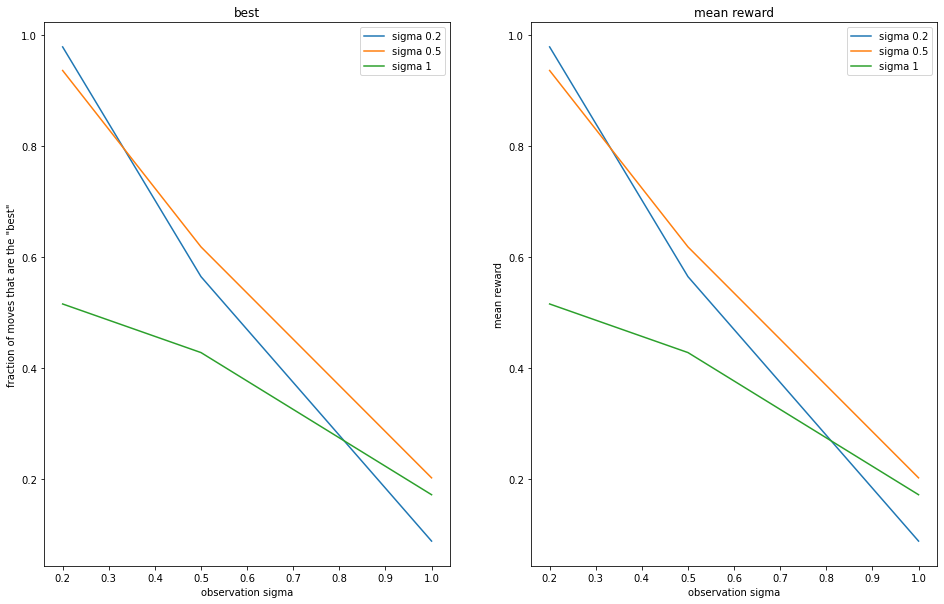

In [30]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16,10))
labels = ['sigma 0.2', 'sigma 0.5', 'sigma 1']
axes[0].set_title('best')
axes[1].set_title('mean reward')
# df1 = pd.read_csv('sigma_best.csv')
x = [0.2,0.5, 1]
for j in range(2):
    for i in range(3):
        axes[j].plot(x, df2.loc[i])
    axes[j].legend(labels)
    axes[j].set_xlabel('observation sigma')
axes[0].set_ylabel('fraction of moves that are the "best"')
axes[1].set_ylabel('mean reward')

# for i in range(3):
#     axes[1].plot(x, df2.loc[i])
# axes[1].legend(labels)
plt.savefig('sigma rates.png')

In [82]:
# rewards = df2['sigma1o2']
# df2['sigma1o2'] = df2['sigma1o5']
# df2['sigma1o5'] = rewards
df2

,sigma1o2
0,0.556583
1,0.620863
2,0.420097


In [51]:
print(b3.episodes['actions'][0])
print(np.sum(b3.episodes['actions'] == b3.episodes['best'])/(len(b3.episodes['actions'])*len(b3.episodes['actions'][0])))
np.sum(b2.episodes['actions'] == 4)/np.sum(b2.episodes['actions'] != 4)
a,b = b2.episodes['actions'].shape
print(b)

[4. 4. 4. 0. 4. 4. 4. 4. 4. 0. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 0. 0.
 4. 4. 4. 4. 0. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 0. 4.
 4. 0. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4.]
0.24693333333333334
100


In [31]:
score_df = pd.read_csv('scores.csv')
wait_df = pd.read_csv('wait_rates.csv')
best_df = pd.read_csv('best_rates.csv')
# print(b.episodes['actions'][0])
# print(b.episodes['best'][0])
# print(np.sum(b.episodes['actions'] == b.episodes['best'])/(b.episodes['actions'].shape[0]*b.episodes['actions'].shape[1]))

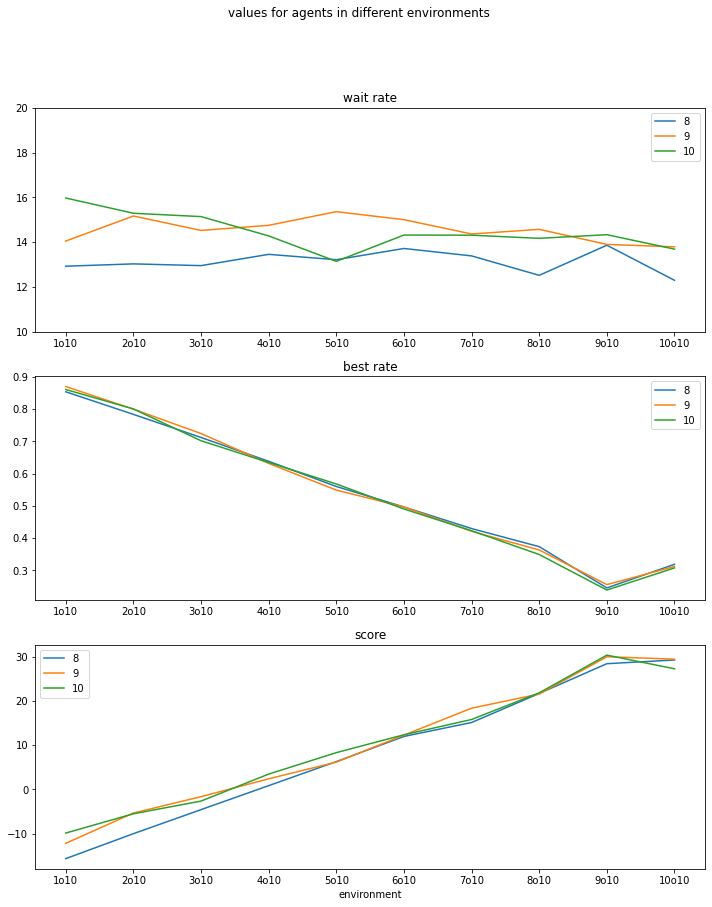

In [32]:
x = [f'{i+1}o10' for i in range(10)]

plt.figure(figsize = (12,14))
plt.subplot(311)
for i in (7,8,9):
    plt.plot(x,wait_df.iloc[i]);
plt.legend(['8','9','10']);
plt.title('wait rate')
plt.ylim(10,20);
plt.subplot(312)
for i in (7,8,9):
    plt.plot(x,best_df.iloc[i]);
plt.legend(['8','9','10']);
plt.title('best rate')
plt.subplot(313)
for i in (7,8,9):
    plt.plot(x,score_df.iloc[i]);
plt.legend(['8','9','10']);
plt.title('score')

plt.suptitle('values for agents in different environments');
plt.xlabel('environment')
plt.savefig('values for agents in different environments.png')





In [24]:
# for k in range(7,10):
scores = np.empty(10)
rates = np.empty(10)
correct = np.empty(10)
#     k += 1
#     # for i in range(4,11):
for i in range(10):
    env = dist_env(n_timesteps = 100,right_reward = 9, wrong_reward = -10, wait_reward = 0)
    name = f"a2c_alex_ratio_{i+1}o10"
    agent = Agent(Model, env, name = name)
    agent.load_agent()
    b = Benchmark(agent, env)
    b.evaluate()
    n, m = b.episodes['actions'].shape
    scores[i] = np.sum(b.episodes['rewards'])/n
    rates[i] = np.sum(b.episodes['actions'] == 4)/np.sum(b.episodes['actions'] != 4)
    correct[i] = np.sum(b.episodes['actions'] == b.episodes['best'])/(n*m)
#     s = np.sum((b.episodes['actions'][:,:] == 4).astype(int), axis = 1)
#     s = s/(100-s)
#     s[s == np.inf] = 100
#     rates.append(sum(s)/300)
#     correct.append(np.sum(b.episodes['actions'] == b.episodes['best'])/(b.episodes['actions'].shape[0]*b.episodes['actions'].shape[1]))
    del env
    del agent
    del b
rates[rates == np.inf] = n*m

index = "9o10"
score_df[index] = scores
wait_df[index] = rates
best_df[index] = correct
    
# wait_rates.append(rates)


# print([a.name for a in agent_list])

C:\Users\Jakob\anaconda3\envs\bioAI2020\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in long_scalars
  app.launch_new_instance()


C:\Users\Jakob\anaconda3\envs\bioAI2020\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in long_scalars
  app.launch_new_instance()


C:\Users\Jakob\anaconda3\envs\bioAI2020\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in long_scalars
  app.launch_new_instance()


C:\Users\Jakob\anaconda3\envs\bioAI2020\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in long_scalars
  app.launch_new_instance()


C:\Users\Jakob\anaconda3\envs\bioAI2020\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in long_scalars
  app.launch_new_instance()


In [25]:
# index = "9o10"
# score_df[index] = scores
# wait_df[index] = rates
# best_df[index] = correct
wait_df.to_csv('wait_rates.csv' , index = False)
best_df.to_csv('best_rates.csv' , index = False)
score_df.to_csv('scores.csv', index = False)
print(best_df)
print(wait_df)
print(score_df)

# df.to_csv('correct_rates.csv', index = False)
# df2 = pd.read_csv('scores.csv')
# df2

       1o10      2o10      3o10      4o10      5o10      6o10      7o10  \
0  0.871033  0.771567  0.682533  0.598667  0.517367  0.443900  0.373800   
1  0.869067  0.770067  0.680267  0.595400  0.517233  0.446467  0.379800   
2  0.865500  0.770367  0.679733  0.597200  0.517533  0.440900  0.370800   
3  0.874767  0.771567  0.679767  0.597200  0.519000  0.446667  0.379000   
4  0.871400  0.774133  0.684900  0.598333  0.516733  0.440933  0.369233   
5  0.866767  0.761767  0.667533  0.583733  0.507467  0.432633  0.366933   
6  0.875333  0.771567  0.674833  0.587067  0.504033  0.431467  0.366467   
7  0.854067  0.783967  0.712267  0.638367  0.560133  0.496567  0.429600   
8  0.870367  0.800133  0.724500  0.631700  0.549033  0.496600  0.421000   
9  0.861167  0.800900  0.702133  0.634667  0.568000  0.490267  0.422900   

       8o10     10o10      9o10  
0  0.314633  0.194167  0.249700  
1  0.310600  0.201467  0.258100  
2  0.317967  0.192567  0.248767  
3  0.325400  0.199033  0.255333  
4  0

In [38]:
plt.rcParams['figure.figsize'] = [15,15]


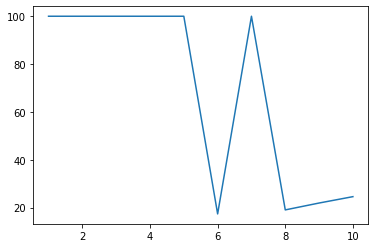

In [23]:

x = np.linspace(1,10,10)
k = 3
plt.plot(x, rates)
# wait_moves = np.where(b.episodes['actions'] ==1)
# s = np.sum((b_list[1].episodes['actions'][:,:] == 4).astype(int), axis = 1)
# s
# s = s/(100-s)
# s[s == np.inf] = 100
# sum(s)/300


In [88]:
l = [[i for i in range(10)], [i for i in range(10,20)]]
with open('wait_rates.txt', 'w') as f:
    for line in wait_rates:
        f.write(str(line) + '\n')

In [129]:
b.episodes['rewards'][0,:]
# b.env.wrong_reward
# sum(np.sum(b_list[0].episodes['rewards'][:,:], axis = 1))/300
# wait_lists.append(wait_to_move_ratio)
# wait_lists
# a = b_list[3].agent
# print(a.name)
# plt.style.use('seaborn')
# plt.plot(np.arange(0, len(a.training_history), 5), a.training_history[::5])
# # plt.plot(np.arange(len(training_history)), training_history)
# plt.xlabel('Episode')
# plt.ylabel('Total Reward')


100

In [31]:
a2_list = [agent_list[i+10] for i in range(10)]
b2_list = [b_list[i+10] for i in range(10)]
# b.plot_rewards()
# b.episodes['values'][0]
# y = (b.episodes['actions'][:50,0] == 4)
# x = np.arange(len(y))
#plt.plot(x, y)
# print(sum(y))
# y2 = b.episodes['actions'][:50,0]
# y3 = b.episodes['observations'][:50,0]
# print(y2.size)
# plt.plot(x,y3, 'go')
# plt.plot(x,y2, 'bo')
#print(y, '\n', y2, '\n', y3)

In [103]:
np.unique(b.episodes['rewards'])

array([-1. , -0.1,  1. ])

In [99]:
class ManualBenchmark:
    def __init__(self, agent):
        self.agent = agent
    
    def play(self):
        agent.model.reset_states()
        state_observation, reward, done, timestep = 0,0,0,0
        action = 4
        while reward > -10:
            # action and reward at t - 1 and timestep at t
            action, value, inputs = agent._predict(action, state_observation, reward, timestep + 1)
            state_observation, reward = input(f"LSTM chose {action}, give me observation and reward").split()
            state_observation = float(state_observation)
            reward = float(reward)
            # rewards, values and actions at t
#             rewards.append(reward)
#             actions.append(action)
#             values.append(value)
            timestep += 1

In [100]:
mb = ManualBenchmark(agent)

In [114]:
mb.play()

LSTM chose [1], give me observation and reward0 0
LSTM chose [0], give me observation and reward0 1
LSTM chose [1], give me observation and reward0 -1
LSTM chose [1], give me observation and reward0 -1
LSTM chose [1], give me observation and reward0 -1
LSTM chose [0], give me observation and reward0 1
LSTM chose [1], give me observation and reward0 -1
LSTM chose [0], give me observation and reward0 1
LSTM chose [1], give me observation and reward0 -1
LSTM chose [0], give me observation and reward0 1
LSTM chose [1], give me observation and reward0 -1
LSTM chose [0], give me observation and reward0 1
LSTM chose [1], give me observation and reward0 -1
LSTM chose [1], give me observation and reward0 -1
LSTM chose [1], give me observation and reward0 -1
LSTM chose [1], give me observation and reward0 -1
LSTM chose [1], give me observation and reward0 -1
LSTM chose [0], give me observation and reward0 1
LSTM chose [1], give me observation and reward0 -1
LSTM chose [0], give me observation an